# Running CHEASE actor

In [1]:
using Revise
using FUSE
using Plots; gr();
global_logger(FUSE.logger);

┌ Info: Precompiling FUSE [e64856f0-3bb8-4376-b4b7-c03396503992]
└ @ Base loading.jl:1423


WebIO._IJuliaInit()

### Initialize the ITER case from ODS
[ITER case documentation](https://fuse.help/cases.html#ITER)

In [2]:
dd, ini, act = FUSE.init(:ITER, init_from=:ods);

┌ Warning: dd.dataset_description was skipped in IMAS data dictionary
└ @ IMASDD ~/.julia/dev/IMASDD/src/data.jl:1078


#### Let's run the ActorCHEASE and compare with original equlibrium

[CHEASE actor](https://fuse.help/actors.html#CHEASE) documentation

NOTE: CHEASE is a fixed boundary equilibrium solver. Extension of the magnetic field calculation in the vacuum region (including X-points) can be triggered by setting `act.ActorCHEASE.free_boundary = true`. This is the default behavior in FUSE, since diverted plasma information is needed to proceed with build and divertor actors.

             now will see if namelist given in file: 'chease_namelist'
  parameters not associated
 NITMOPT =            0
  k1=          182  k2=           40
 eqchease_out(index_out)%profiles_1d%psi(1)=    0.0000000000000000     
 eqchease_out(index_out)%profiles_1d%psi(nbprofiles1d)=    5.7061359641977907E-002
 minval(EQDSPSI)=   -5.7059266234810495E-002
 maxval(EQDSPSI)=   0.12575139382456391     


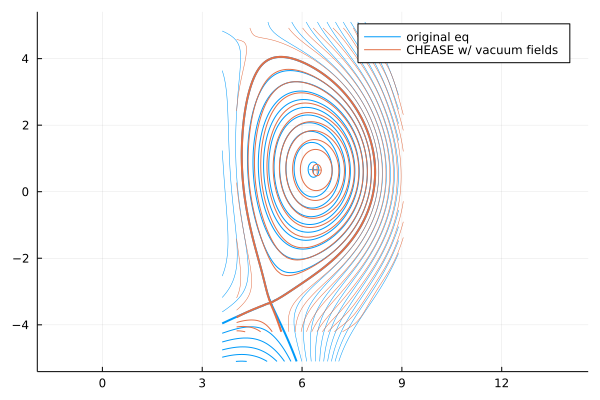

In [3]:
dd, ini, act = FUSE.init(:ITER, init_from=:ods);
eq_plot = plot(dd.equilibrium, label="original eq")
act.ActorCHEASE.free_boundary = true
actor = FUSE.ActorCHEASE(dd, act);
display(plot!(eq_plot, dd.equilibrium, label="CHEASE w/ vacuum fields"))

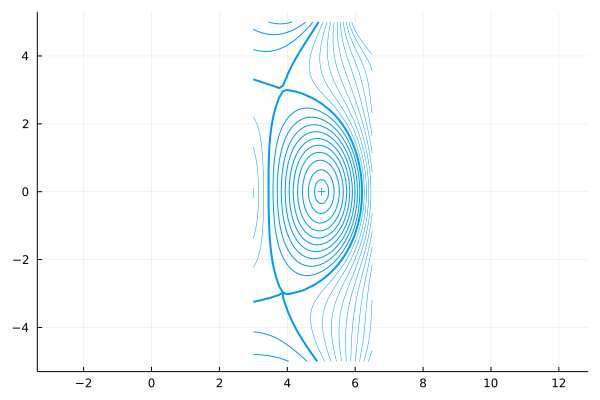

LoadError: Cannot convert IMASDD.equilibrium__time_slice___boundary to series data for plotting

In [4]:
ini, act = FUSE.case_parameters(:FPP; version=:v1_demount, init_from=:ods);
dd = IMAS.dd()
FUSE.init(dd, ini, act; do_plot=true);


### Update equilibrium after transport run

Run transport calculation followed by the calculation of the steady-state current

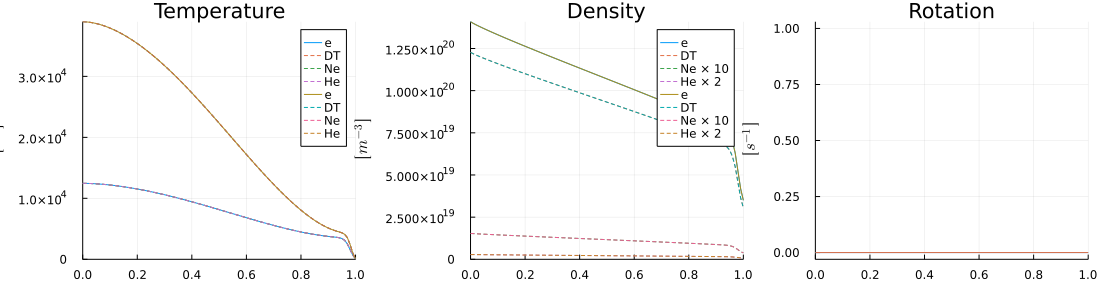

In [5]:
dd, ini, act = FUSE.init(:ITER,init_from=:ods);

core_profiles_plot = plot(dd.core_profiles)
FUSE.ActorSteadyStateCurrent(dd,act)
FUSE.ActorTauenn(dd,act)
plot!(core_profiles_plot,dd.core_profiles)

Then we update equilibrium: